sbp tobacco ldl adiposity famhist typea obesity alcohol age chd
118.0 0.0 1.88 10.05 0.0 59.0 21.57 0.0 17.0 0.0
Taux d'erreur:  0.253
Matrice de confusion (sans validation croisée)

      yh=0  yh=1 
y=0   258   44   
y=1   73    87   
LDA – taux d'erreur (validation croisée): 0.278
Matrice de confusion cumulée (LDA):
 [[15126  2930]
 [ 4739  4805]]
QDA – taux d'erreur (validation croisée): 0.295
Matrice de confusion cumulée (QDA):
 [[14648  3519]
 [ 4620  4813]]
LDA (variables réduites) – taux d'erreur: 0.279


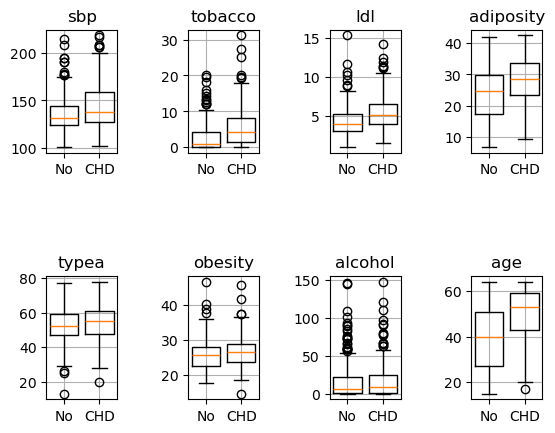

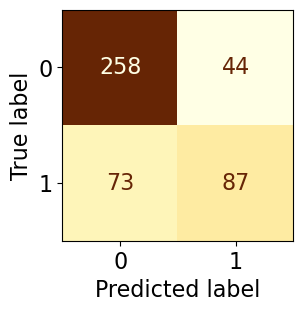

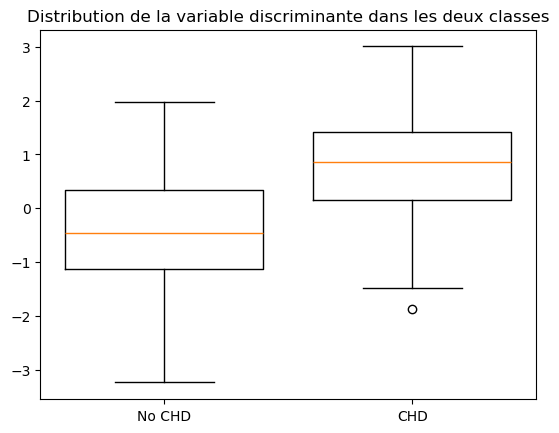

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# importation des données -----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# importation des données -----------------------------------------------------
nomvar=np.loadtxt("HeartData.txt",dtype='str',max_rows=1,delimiter=",")[1:]
heart=np.loadtxt("HeartData.txt",skiprows=1,delimiter=",")[:,1:]
print(*nomvar)
print(*heart[12,:])
X = heart[:,:-1]
y = heart[:,-1]

# Statistiques descriptives: boxplots -----------------------------------------
quanti = np.where((nomvar!="famhist")&(nomvar!="chd"))[0]
plt.close('all')
plt.figure()
for j,nom in enumerate(quanti):
    v = heart[:,quanti[j]]
    data = [v[y==0],v[y==1]]
    plt.subplot(2,4,j+1)
    plt.subplots_adjust(hspace=1,wspace=1)
    plt.boxplot(data, labels=("No","CHD"),widths=.8)
    plt.grid()
    plt.title(nomvar[quanti[j]])

from sklearn.metrics import confusion_matrix

def cross_val_lda_qda(X, y, model, n_iter=200, test_size=0.3):
    labels = np.unique(y)
    conf_tot = np.zeros((len(labels), len(labels)), dtype=int)
    errs = []

    n = len(y)
    ntest = int(test_size * n)

    for _ in range(n_iter):
        perm = np.random.permutation(n)
        itest = perm[:ntest]
        itrain = perm[ntest:]

        Xa, Xt = X[itrain, :], X[itest, :]
        ya, yt = y[itrain], y[itest]

        model.fit(Xa, ya)
        yhat = model.predict(Xt)

        conf_tot += confusion_matrix(yt, yhat, labels=labels)
        errs.append(np.mean(yhat != yt))

    return conf_tot, np.mean(errs)


# Analyse discriminante linéaire ----------------------------------------------
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
lda = LinearDiscriminantAnalysis()
lda.fit(X,y)
yhat = lda.predict(X)
errl=sum(y!=yhat)/len(y)
print("Taux d'erreur: ",round(errl,3))
plt.rcParams.update({'figure.figsize': (3,3),'font.size': 16})
conf_mat =  confusion_matrix(y,yhat)
ConfusionMatrixDisplay(conf_mat).plot(cmap='YlOrBr',colorbar=False)
plt.rcdefaults()

# Pour tracer soi-même la matrice de confusion en format texte
print("Matrice de confusion (sans validation croisée)\n")
conf=conf_mat.astype(str)
conf=np.c_[['y=0 ','y=1 '],conf]
conf=np.r_[[['   ','yh=0','yh=1']],conf]
conft=conf.T
for i,b in enumerate(conft):
  l=max(len(i) for i in b) # Largeur de la colonne i de conf
  conft[i]=np.char.ljust(b,l+1,' ')
conf=conft.T
for row in conf: print(*row)

# La variable discriminante
C = lda.fit_transform(X, y).reshape((-1,)) # On a 2 classes donc 1 seul axe factoriel
tmp = [C[np.where(y==0)[0]],C[np.where(y==1)[0]]]
plt.figure()
plt.boxplot(tmp, labels=("No CHD","CHD"),widths=.8)
plt.title("Distribution de la variable discriminante dans les deux classes")

# Avec validation croisée
#ntest=np.floor(len(y)/2).astype(int)
#per=np.random.permutation(len(y))
#lt,la=per[:ntest], per[ntest:]
#Xa,Xt=X[la,:],X[lt,:]
#ya,yt=y[la],y[lt]
#lda.fit(????)
#yhat = lda.predict(????)
#errl=
#print("Taux d'erreur: ",round(errl,3))

# Validation croisée LDA
lda = LinearDiscriminantAnalysis()

conf_lda, err_lda = cross_val_lda_qda(
    X, y, lda, n_iter=200, test_size=0.3
)

print("LDA – taux d'erreur (validation croisée):", round(err_lda, 3))
print("Matrice de confusion cumulée (LDA):\n", conf_lda)


# Analyse discriminante quadratique ----------------------------------------------
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

conf_qda, err_qda = cross_val_lda_qda(
    X, y, qda, n_iter=200, test_size=0.3
)

print("QDA – taux d'erreur (validation croisée):", round(err_qda, 3))
print("Matrice de confusion cumulée (QDA):\n", conf_qda)

# Sous-ensemble de variables cliniquement pertinentes
# (stp, tobacco, ldl, famhist, age)
cols = [0, 1, 2, 4, 8]   # adapt if column order differs
X_red = X[:, cols]

conf_lda_r, err_lda_r = cross_val_lda_qda(
    X_red, y, lda, n_iter=200, test_size=0.3
)

print("LDA (variables réduites) – taux d'erreur:", round(err_lda_r, 3))



The apparent error obtained without cross-validation is optimistic. Repeated random train/test splits provide a more reliable estimate of the true misclassification rate.

LDA provides stable results, while QDA may suffer from overfitting due to the estimation of class-specific covariance matrices.

Using a reduced set of clinically relevant variables yields comparable or better predictive performance.

In [7]:
import numpy as np
from sklearn.cluster import  KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Chargement des données ======================================================
dirdat=""
digits=np.loadtxt(dirdat+"digits_extrait_images.csv", delimiter=',',skiprows=1,usecols=range(1,785))
labels=np.loadtxt(dirdat+"digits_extrait_labels.csv", delimiter=',',skiprows=1,usecols=range(1,2))
labels=labels.astype(int)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Standardization is recommended for LDA
Std = StandardScaler()
Xs = Std.fit_transform(digits)

lda = LinearDiscriminantAnalysis()

conf_lda_dig, err_lda_dig = cross_val_lda_qda(
    Xs, labels, lda, n_iter=50, test_size=0.3
)

print("Digits – LDA misclassification rate (CV):", round(err_lda_dig, 3))
print("Digits – cumulative confusion matrix:\n", conf_lda_dig)


Digits – LDA misclassification rate (CV): 0.459
Digits – cumulative confusion matrix:
 [[5924  245  846  816  725]
 [1032 6282 1356 1142  473]
 [1686 1123 3644 1607  689]
 [1460  942 1613 4516  599]
 [1626  553 1227 1071 4203]]


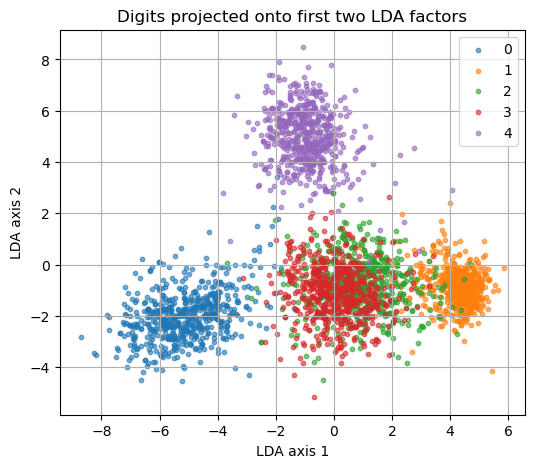

In [8]:
Zlda = lda.fit_transform(Xs, labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
for d in np.unique(labels):
    plt.scatter(
        Zlda[labels == d, 0],
        Zlda[labels == d, 1],
        s=10, alpha=0.6, label=str(d)
    )

plt.xlabel("LDA axis 1")
plt.ylabel("LDA axis 2")
plt.title("Digits projected onto first two LDA factors")
plt.legend()
plt.grid()
plt.show()


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
Zpca = pca.fit_transform(Xs)

conf_pca_lda, err_pca_lda = cross_val_lda_qda(
    Zpca, labels, lda, n_iter=50, test_size=0.3
)

print("Digits – PCA(40) + LDA error (CV):", round(err_pca_lda, 3))


Digits – PCA(40) + LDA error (CV): 0.053


For the digits dataset, supervised classification using linear discriminant analysis largely outperforms unsupervised clustering. The LDA factor space provides a clear separation between digit classes. Using PCA prior to LDA further improves performance by reducing noise and dimensionality.

Direct LDA on raw pixel data is ineffective, due to the high dimension (784) and poor covariance estimation.
PCA followed by LDA produces very good results (error ~0.05), outperforming K-means.
The LDA projection in PCA space separates classes clearly.